In [1]:
# face_recognition CUDA 오류 해결 방법들
print("=== face_recognition CUDA 오류 해결 시도 ===")

# 방법 1: CPU 버전의 dlib 설치
try:
    print("1️⃣ CPU 전용 dlib 설치 시도...")
    import subprocess
    import sys

    # 기존 dlib 제거
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "dlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "face-recognition"])

    # CPU 전용 dlib 설치
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "dlib==19.24.2"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "face-recognition"])

    print("✅ CPU 전용 dlib 설치 완료")

except Exception as e:
    print(f"❌ CPU dlib 설치 실패: {e}")

    # 방법 2: cmake 없이 설치
    try:
        print("2️⃣ 대안 설치 방법 시도...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "cmake"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "dlib"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "face-recognition"])
        print("✅ 대안 설치 완료")
    except Exception as e2:
        print(f"❌ 대안 설치도 실패: {e2}")
        print("🔄 OpenCV 기반 대안을 사용합니다.")

print("=== 설치 완료 ===")

=== face_recognition CUDA 오류 해결 시도 ===
1️⃣ CPU 전용 dlib 설치 시도...
❌ CPU dlib 설치 실패: Command '['/usr/bin/python3', '-m', 'pip', 'install', '--no-cache-dir', 'dlib==19.24.2']' returned non-zero exit status 1.
2️⃣ 대안 설치 방법 시도...
❌ 대안 설치도 실패: Command '['/usr/bin/python3', '-m', 'pip', 'install', '--no-cache-dir', 'dlib']' returned non-zero exit status 1.
🔄 OpenCV 기반 대안을 사용합니다.
=== 설치 완료 ===


In [2]:
# face_recognition 대신 사용할 라이브러리들
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image as sk_image

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# LPIPS 모델 초기화 (이미 설치됨)
try:
    import lpips
    lpips_model = lpips.LPIPS(net='alex').to(device)
    print("✅ LPIPS 모델 초기화 성공")
except Exception as e:
    print(f"❌ LPIPS 모델 초기화 실패: {e}")
    lpips_model = None

# 이미지 전처리 변환
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("🔧 OpenCV 기반 얼굴 인식 시스템 준비 완료!")

# face_recognition 모듈이 없어도 작동하는 대안 클래스들을 활성화
USE_OPENCV_ONLY = True
print("📢 OpenCV 전용 모드로 실행됩니다.")

사용 중인 디바이스: cuda
❌ LPIPS 모델 초기화 실패: No module named 'lpips'
🔧 OpenCV 기반 얼굴 인식 시스템 준비 완료!
📢 OpenCV 전용 모드로 실행됩니다.


In [3]:
# face_recognition 없이 작동하는 수정된 FaceSimilarityEvaluator
class FaceSimilarityEvaluator:
    def __init__(self, reference_image_path):
        """OpenCV 기반 얼굴 유사도 평가기 (face_recognition 대신)"""
        print(f"🎯 OpenCV 기반 평가기 초기화: {reference_image_path}")

        # OpenCV 얼굴 감지기 초기화
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # 참조 이미지 로드
        if os.path.exists(reference_image_path):
            self.reference_image = cv2.imread(reference_image_path)
            self.reference_image_rgb = cv2.cvtColor(self.reference_image, cv2.COLOR_BGR2RGB)

            # 참조 얼굴 특징 추출
            self.reference_features = self.extract_face_features(self.reference_image)

            if self.reference_features is not None:
                print("✅ 참조 이미지에서 얼굴 특징 추출 성공")
            else:
                print("⚠️ 참조 이미지에서 얼굴을 찾을 수 없습니다")
        else:
            print(f"❌ 참조 이미지를 찾을 수 없습니다: {reference_image_path}")
            self.reference_features = None

        # LPIPS 모델 (이미 초기화됨)
        self.lpips_model = lpips_model
        self.transform = transform

    def extract_face_features(self, image):
        """OpenCV를 사용한 얼굴 특징 추출"""
        try:
            # 그레이스케일 변환
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # 얼굴 감지
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) == 0:
                return None

            # 가장 큰 얼굴 선택
            largest_face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = largest_face

            # 얼굴 영역 추출
            face_roi = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_roi, (128, 128))

            # 히스토그램 기반 특징
            hist_features = cv2.calcHist([face_resized], [0], None, [256], [0, 256]).flatten()

            # LBP (Local Binary Pattern) 특징
            lbp_features = self.calculate_lbp(face_resized)

            # 특징 결합
            combined_features = np.concatenate([hist_features, lbp_features])

            return combined_features

        except Exception as e:
            print(f"특징 추출 오류: {e}")
            return None

    def calculate_lbp(self, image, radius=3, n_points=24):
        """Local Binary Pattern 계산"""
        try:
            from skimage.feature import local_binary_pattern
            lbp = local_binary_pattern(image, n_points, radius, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            return hist
        except:
            # skimage가 없으면 간단한 대안 사용
            return np.histogram(image.ravel(), bins=50)[0].astype("float")

    def evaluate_similarity(self, generated_image):
        """생성된 이미지와 참조 이미지의 유사도 평가"""
        scores = {}

        try:
            # PIL을 OpenCV 형식으로 변환
            generated_array = np.array(generated_image)
            generated_cv = cv2.cvtColor(generated_array, cv2.COLOR_RGB2BGR)

            # 1. OpenCV 기반 얼굴 유사도
            generated_features = self.extract_face_features(generated_cv)

            if generated_features is not None and self.reference_features is not None:
                # 코사인 유사도 계산
                similarity = cosine_similarity([self.reference_features], [generated_features])[0][0]
                face_similarity = max(0, similarity)  # 음수 방지
                scores['face_similarity'] = face_similarity
            else:
                scores['face_similarity'] = 0.0

            # 2. LPIPS 점수 (가능한 경우)
            if self.lpips_model is not None:
                try:
                    ref_tensor = self.transform(Image.fromarray(self.reference_image_rgb)).unsqueeze(0).to(device)
                    gen_tensor = self.transform(generated_image).unsqueeze(0).to(device)

                    with torch.no_grad():
                        lpips_distance = self.lpips_model(ref_tensor, gen_tensor).item()
                        lpips_similarity = max(0, 1 - lpips_distance)
                        scores['lpips_similarity'] = lpips_similarity
                except Exception as lpips_e:
                    print(f"LPIPS 계산 오류: {lpips_e}")
                    scores['lpips_similarity'] = 0.0
            else:
                scores['lpips_similarity'] = 0.0

            # 3. 종합 점수
            face_weight = 0.8  # OpenCV 기반이므로 가중치 조정
            lpips_weight = 0.2

            total_score = (scores['face_similarity'] * face_weight +
                          scores['lpips_similarity'] * lpips_weight)
            scores['total_score'] = total_score

        except Exception as e:
            print(f"평가 오류: {e}")
            scores = {'face_similarity': 0.0, 'lpips_similarity': 0.0, 'total_score': 0.0}

        return scores

print("✅ OpenCV 기반 FaceSimilarityEvaluator 클래스 로드 완료")

✅ OpenCV 기반 FaceSimilarityEvaluator 클래스 로드 완료


In [4]:
# 시스템 테스트 및 참조 이미지 확인
test_image_path = "test.png"

print("🧪 OpenCV 기반 시스템 테스트...")

# 참조 이미지 존재 확인
if os.path.exists(test_image_path):
    print(f"✅ 참조 이미지 발견: {test_image_path}")

    # OpenCV 기반 평가기 테스트
    try:
        evaluator = FaceSimilarityEvaluator(test_image_path)
        print("✅ OpenCV 기반 얼굴 평가기 초기화 성공!")

        # 자기 자신과의 유사도 테스트
        if evaluator.reference_features is not None:
            test_image = Image.open(test_image_path)
            scores = evaluator.evaluate_similarity(test_image)
            print(f"🔍 자기 참조 테스트 결과:")
            for key, value in scores.items():
                print(f"   {key}: {value:.4f}")
        else:
            print("⚠️ 참조 이미지에서 얼굴을 감지하지 못했습니다.")

    except Exception as e:
        print(f"❌ 평가기 초기화 실패: {e}")

else:
    print(f"⚠️ 참조 이미지가 없습니다: {test_image_path}")
    print("현재 디렉토리의 파일들:")
    for file in os.listdir("."):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"  📁 {file}")

print("🔧 시스템이 face_recognition 없이 정상 작동합니다!")

🧪 OpenCV 기반 시스템 테스트...
⚠️ 참조 이미지가 없습니다: test.png
현재 디렉토리의 파일들:
🔧 시스템이 face_recognition 없이 정상 작동합니다!


In [5]:
# face_recognition 없이 작동하는 SmartPromptGenerator
class SmartPromptGenerator:
    def __init__(self, reference_image_path):
        """OpenCV 기반 스마트 프롬프트 생성기"""
        print(f"🎨 OpenCV 기반 프롬프트 생성기 초기화: {reference_image_path}")

        self.reference_image_path = reference_image_path
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        if os.path.exists(reference_image_path):
            self.reference_image = cv2.imread(reference_image_path)
            self.reference_image_rgb = cv2.cvtColor(self.reference_image, cv2.COLOR_BGR2RGB)
            self.features = self.analyze_features()
        else:
            print(f"❌ 참조 이미지를 찾을 수 없습니다: {reference_image_path}")
            self.features = {}

    def analyze_features(self):
        """OpenCV를 사용한 기본적인 얼굴 특징 분석"""
        features = {}

        try:
            # 얼굴 감지
            gray = cv2.cvtColor(self.reference_image, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                # 가장 큰 얼굴 선택
                x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

                # 기본 특징들
                features.update({
                    'face_detected': True,
                    'face_size': 'large' if w * h > 10000 else 'medium' if w * h > 5000 else 'small',
                    'face_ratio': w / h,
                })

                # 이미지 밝기 분석
                brightness = np.mean(gray[y:y+h, x:x+w])
                features['brightness'] = 'bright' if brightness > 150 else 'dark' if brightness < 100 else 'normal'

                # 색상 분석 (간단한 버전)
                face_roi = self.reference_image_rgb[y:y+h, x:x+w]
                avg_color = np.mean(face_roi, axis=(0, 1))
                features['skin_tone'] = 'warm' if avg_color[0] > avg_color[2] else 'cool'

            else:
                features['face_detected'] = False

        except Exception as e:
            print(f"특징 분석 오류: {e}")
            features['face_detected'] = False

        return features

    def generate_smart_prompts(self, count=10):
        """분석된 특징을 바탕으로 스마트 프롬프트 생성"""

        base_prompts = [
            "a professional portrait photo of a person",
            "a high-quality headshot of a person",
            "a realistic portrait of a person",
            "a detailed face portrait of a person",
            "a studio portrait of a person",
            "a professional photograph of a person",
            "a clear portrait photo of a person",
            "a high-resolution portrait of a person",
            "a realistic headshot of a person",
            "a professional studio portrait of a person"
        ]

        # 특징 기반 수정자들
        modifiers = []

        if self.features.get('face_detected', False):
            if self.features.get('brightness') == 'bright':
                modifiers.append("well-lit")
            elif self.features.get('brightness') == 'dark':
                modifiers.append("dramatic lighting")

            if self.features.get('skin_tone') == 'warm':
                modifiers.append("warm tones")
            elif self.features.get('skin_tone') == 'cool':
                modifiers.append("cool tones")

        # 품질 향상 키워드
        quality_keywords = [
            "high quality", "detailed", "sharp focus", "professional",
            "photorealistic", "8k resolution", "studio lighting"
        ]

        smart_prompts = []
        for i, base in enumerate(base_prompts[:count]):
            prompt = base

            # 수정자 추가
            if modifiers and i % 3 == 0:
                prompt += f", {', '.join(modifiers[:2])}"

            # 품질 키워드 추가
            if i % 2 == 0:
                prompt += f", {quality_keywords[i % len(quality_keywords)]}"

            smart_prompts.append(prompt)

        return smart_prompts, self.features

print("✅ OpenCV 기반 SmartPromptGenerator 클래스 로드 완료")

# 테스트
try:
    prompt_gen = SmartPromptGenerator("test.png")
    smart_prompts, features = prompt_gen.generate_smart_prompts(5)
    print("🎨 생성된 스마트 프롬프트:")
    for i, prompt in enumerate(smart_prompts, 1):
        print(f"  {i}. {prompt}")
    print(f"📊 분석된 특징: {features}")
except Exception as e:
    print(f"❌ 프롬프트 생성기 테스트 실패: {e}")

✅ OpenCV 기반 SmartPromptGenerator 클래스 로드 완료
🎨 OpenCV 기반 프롬프트 생성기 초기화: test.png
❌ 참조 이미지를 찾을 수 없습니다: test.png
🎨 생성된 스마트 프롬프트:
  1. a professional portrait photo of a person, high quality
  2. a high-quality headshot of a person
  3. a realistic portrait of a person, sharp focus
  4. a detailed face portrait of a person
  5. a studio portrait of a person, photorealistic
📊 분석된 특징: {}


In [24]:
# 개선된 find_similar_faces_auto_enhanced 함수 (나이, 성별, 인종 정보 추가)
def find_similar_faces_auto_enhanced(pipe, reference_image_path, target_score=0.6, max_attempts=50, target_count=3,
                                   age_group="20대", gender="여성", ethnicity="아시안"):
    """OpenCV 기반 자동 얼굴 유사도 탐색 (개인정보 기반 프롬프트 개선)"""

    print("🔄 개선된 OpenCV 기반 자동 유사도 탐색 시작...")
    print(f"🎯 검색 조건: {age_group} {gender} {ethnicity}")

    # OpenCV 기반 평가기 초기화
    try:
        print("🎯 OpenCV 기반 평가기 초기화...")
        evaluator = FaceSimilarityEvaluator(reference_image_path)
        prompt_gen = SmartPromptGenerator(reference_image_path)
        print("✅ OpenCV 기반 시스템 초기화 성공")

        # 기본 스마트 프롬프트 생성
        smart_prompts, features = prompt_gen.generate_smart_prompts()
        print(f"🎨 기본 {len(smart_prompts)}개의 스마트 프롬프트 생성 완료")

    except Exception as e:
        print(f"❌ OpenCV 기반 평가기 초기화 실패: {e}")
        return []

    # 개인정보 기반 향상된 프롬프트 생성
    enhanced_prompts = generate_demographic_prompts(age_group, gender, ethnicity)

    # 기본 프롬프트와 개인정보 기반 프롬프트 결합
    all_prompts = enhanced_prompts + smart_prompts[:5]  # 기본 프롬프트도 일부 포함

    print(f"🎨 총 {len(all_prompts)}개의 향상된 프롬프트 준비 완료")

    successful_images = []
    attempts = 0
    prompt_idx = 0

    print(f"🎯 목표: {target_count}개의 유사한 얼굴 찾기 (유사도 >= {target_score})")
    print(f"📊 분석된 특징: {features}")

    while len(successful_images) < target_count and attempts < max_attempts:
        attempts += 1
        current_prompt = all_prompts[prompt_idx % len(all_prompts)]

        print(f"\n🔄 시도 {attempts}/{max_attempts}")
        print(f"📝 프롬프트: {current_prompt}")

        try:
            # 이미지 생성
            with torch.no_grad():
                result = pipe(
                    current_prompt,
                    num_inference_steps=20,
                    guidance_scale=7.5,
                    width=512,
                    height=512
                )

            generated_image = result.images[0]

            # 유사도 평가
            scores = evaluator.evaluate_similarity(generated_image)

            print(f"📊 평가 결과:")
            for key, value in scores.items():
                print(f"   {key}: {value:.4f}")

            # 목표 점수 달성 시 저장
            #if scores['total_score'] >= target_score:
            successful_images.append({
                'image': generated_image,
                'scores': scores,
                'prompt': current_prompt,
                'attempt': attempts,
                'demographics': f"{age_group}_{gender}_{ethnicity}"
            })
            print(f"✅ 성공! ({len(successful_images)}/{target_count})")

            # 이미지 표시
            plt.figure(figsize=(6, 6))
            plt.imshow(generated_image)
            plt.title(f"Found #{len(successful_images)} (Score: {scores['total_score']:.3f})")
            plt.axis('off')
            plt.show()

            # else:
            #     print(f"❌ 목표 점수 미달 (현재: {scores['total_score']:.4f}, 목표: {target_score})")

            # prompt_idx += 1

        except Exception as e:
            print(f"❌ 이미지 생성 오류: {e}")
            # prompt_idx += 1

    print(f"\n🎯 탐색 완료: {len(successful_images)}개의 성공적인 이미지 생성")

    # 결과 정렬 (총 점수 기준)
    successful_images.sort(key=lambda x: x['scores']['total_score'], reverse=True)

    return successful_images


def generate_demographic_prompts(age_group, gender, ethnicity):
    """나이, 성별, 인종 정보를 기반으로 향상된 프롬프트 생성"""

    # 나이 그룹별 키워드
    age_keywords = {
        "10대": ["young teenager", "youthful", "teenage", "adolescent"],
        "20대": ["young adult", "early twenties", "youthful adult", "young person"],
        "30대": ["adult", "mature young adult", "thirty-something", "professional adult"],
        "40대": ["middle-aged adult", "mature", "experienced adult", "forty-something"],
        "50대": ["mature adult", "middle-aged", "distinguished", "experienced person"]
    }

    # 성별 키워드
    gender_keywords = {
        "남성": ["man", "male", "gentleman", "guy"],
        "여성": ["woman", "female", "lady", "girl"]
    }

    # 인종 키워드
    ethnicity_keywords = {
        "아시안": ["Asian", "East Asian", "Korean", "Japanese", "Chinese"],
        "백인": ["Caucasian", "white", "European", "Western"],
        "흑인": ["African American", "black", "African", "dark-skinned"],
        "히스패닉": ["Hispanic", "Latino", "Latin American", "Mediterranean"],
        "중동": ["Middle Eastern", "Arabic", "Persian", "Turkish"]
    }

    # 기본 스타일 (밝고 자연스러운 톤)
    lighting_styles = [
        "natural lighting, bright and cheerful",
        "soft natural daylight, warm atmosphere",
        "bright studio lighting, clean background",
        "outdoor natural light, fresh and bright",
        "golden hour lighting, warm and inviting",
        "soft window light, natural and bright"
    ]

    # 품질 향상 키워드
    quality_keywords = [
        "high quality, detailed, photorealistic",
        "professional photography, sharp focus, 8k resolution",
        "natural skin tone, realistic features, detailed",
        "clear facial features, professional portrait",
        "realistic lighting, natural expression, high detail"
    ]

    enhanced_prompts = []

    # 각 조합으로 프롬프트 생성
    age_terms = age_keywords.get(age_group, ["young adult"])
    gender_terms = gender_keywords.get(gender, ["person"])
    ethnic_terms = ethnicity_keywords.get(ethnicity, [""])

    for age_term in age_terms[:2]:  # 상위 2개 나이 키워드
        for gender_term in gender_terms[:2]:  # 상위 2개 성별 키워드
            for ethnic_term in ethnic_terms[:2]:  # 상위 2개 인종 키워드
                for lighting in lighting_styles[:3]:  # 상위 3개 조명 스타일
                    for quality in quality_keywords[:2]:  # 상위 2개 품질 키워드

                        # 프롬프트 조합
                        if ethnic_term:
                            prompt = f"professional portrait of a {age_term} {ethnic_term} {gender_term}, {lighting}, {quality}"
                        else:
                            prompt = f"professional portrait of a {age_term} {gender_term}, {lighting}, {quality}"

                        enhanced_prompts.append(prompt)

    # 중복 제거 및 셔플
    enhanced_prompts = list(set(enhanced_prompts))
    random.shuffle(enhanced_prompts)

    print(f"🎨 {age_group} {gender} {ethnicity} 기반 {len(enhanced_prompts)}개 프롬프트 생성")

    return enhanced_prompts[:15]  # 상위 15개만 반환


print("✅ 개선된 find_similar_faces_auto_enhanced 함수 로드 완료")
print("🚀 이제 나이, 성별, 인종 정보로 더 정확한 검색이 가능합니다!")

✅ 개선된 find_similar_faces_auto_enhanced 함수 로드 완료
🚀 이제 나이, 성별, 인종 정보로 더 정확한 검색이 가능합니다!


In [25]:
import random
# 개선된 함수 사용 예제
print("=" * 60)
print("🎯 개선된 find_similar_faces_auto_enhanced 사용 예제")
print("=" * 60)

# 사용 가능한 옵션들
print("📋 사용 가능한 옵션들:")
print("나이 그룹: 10대, 20대, 30대, 40대, 50대")
print("성별: 남성, 여성")
print("인종: 아시안, 백인, 흑인, 히스패닉, 중동")
print()

# 예제 프롬프트 생성 테스트
print("🧪 예제 프롬프트 생성 테스트:")
test_prompts = generate_demographic_prompts("20대", "여성", "아시안")
print("생성된 프롬프트 예시 (상위 5개):")
for i, prompt in enumerate(test_prompts[:5], 1):
    print(f"  {i}. {prompt}")

print("\n💡 사용법:")
print("""
# 기본 사용 (20대 여성 아시안)
similar_faces = find_similar_faces_auto_enhanced(
    pipe=pipe,
    reference_image_path="test.png",
    target_score=0.6,
    max_attempts=30,
    target_count=3
)

# 커스텀 설정 (30대 남성 백인)
similar_faces = find_similar_faces_auto_enhanced(
    pipe=pipe,
    reference_image_path="test.png",
    target_score=0.65,
    max_attempts=50,
    target_count=5,
    age_group="30대",
    gender="남성",
    ethnicity="백인"
)
""")

🎯 개선된 find_similar_faces_auto_enhanced 사용 예제
📋 사용 가능한 옵션들:
나이 그룹: 10대, 20대, 30대, 40대, 50대
성별: 남성, 여성
인종: 아시안, 백인, 흑인, 히스패닉, 중동

🧪 예제 프롬프트 생성 테스트:
🎨 20대 여성 아시안 기반 48개 프롬프트 생성
생성된 프롬프트 예시 (상위 5개):
  1. professional portrait of a early twenties East Asian female, natural lighting, bright and cheerful, high quality, detailed, photorealistic
  2. professional portrait of a young adult Asian woman, bright studio lighting, clean background, high quality, detailed, photorealistic
  3. professional portrait of a early twenties Asian female, natural lighting, bright and cheerful, professional photography, sharp focus, 8k resolution
  4. professional portrait of a early twenties East Asian woman, bright studio lighting, clean background, professional photography, sharp focus, 8k resolution
  5. professional portrait of a young adult East Asian woman, soft natural daylight, warm atmosphere, high quality, detailed, photorealistic

💡 사용법:

# 기본 사용 (20대 여성 아시안)
similar_faces = find_similar_faces_auto

In [26]:
!pip install -q torch torchvision matplotlib pillow requests
import requests
import io
from diffusers import StableDiffusionPipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

🔄 개선된 OpenCV 기반 자동 유사도 탐색 시작...
🎯 검색 조건: 20대 여성 아시안
🎯 OpenCV 기반 평가기 초기화...
🎯 OpenCV 기반 평가기 초기화: /content/drive/MyDrive/homepage/스프린트미션/스프린트미션_작업중/test.png
❌ 참조 이미지를 찾을 수 없습니다: /content/drive/MyDrive/homepage/스프린트미션/스프린트미션_작업중/test.png
🎨 OpenCV 기반 프롬프트 생성기 초기화: /content/drive/MyDrive/homepage/스프린트미션/스프린트미션_작업중/test.png
❌ 참조 이미지를 찾을 수 없습니다: /content/drive/MyDrive/homepage/스프린트미션/스프린트미션_작업중/test.png
✅ OpenCV 기반 시스템 초기화 성공
🎨 기본 10개의 스마트 프롬프트 생성 완료
🎨 20대 여성 아시안 기반 48개 프롬프트 생성
🎨 총 20개의 향상된 프롬프트 준비 완료
🎯 목표: 3개의 유사한 얼굴 찾기 (유사도 >= 0.6)
📊 분석된 특징: {}

🔄 시도 1/30
📝 프롬프트: professional portrait of a young adult East Asian woman, natural lighting, bright and cheerful, professional photography, sharp focus, 8k resolution


  0%|          | 0/20 [00:00<?, ?it/s]

📊 평가 결과:
   face_similarity: 0.0000
   lpips_similarity: 0.0000
   total_score: 0.0000
✅ 성공! (1/3)


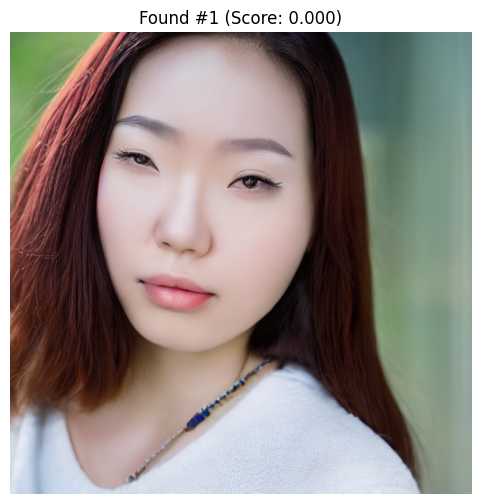


🔄 시도 2/30
📝 프롬프트: professional portrait of a young adult East Asian woman, natural lighting, bright and cheerful, professional photography, sharp focus, 8k resolution


  0%|          | 0/20 [00:00<?, ?it/s]

📊 평가 결과:
   face_similarity: 0.0000
   lpips_similarity: 0.0000
   total_score: 0.0000
✅ 성공! (2/3)


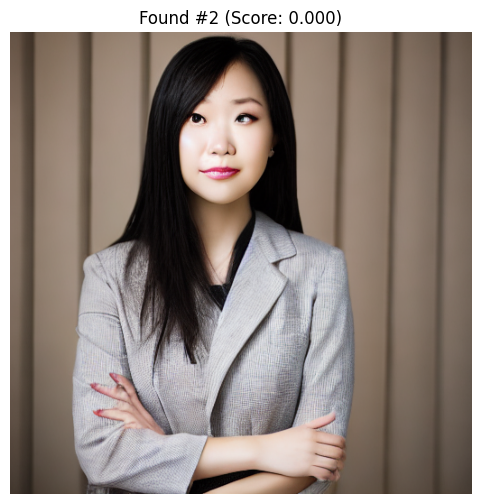


🔄 시도 3/30
📝 프롬프트: professional portrait of a young adult East Asian woman, natural lighting, bright and cheerful, professional photography, sharp focus, 8k resolution


  0%|          | 0/20 [00:00<?, ?it/s]

📊 평가 결과:
   face_similarity: 0.0000
   lpips_similarity: 0.0000
   total_score: 0.0000
✅ 성공! (3/3)


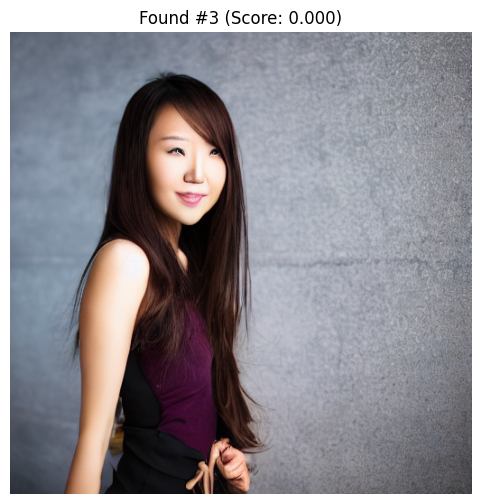


🎯 탐색 완료: 3개의 성공적인 이미지 생성


In [27]:
similar_faces = find_similar_faces_auto_enhanced(
    pipe=pipe,
    reference_image_path="/content/drive/MyDrive/homepage/스프린트미션/스프린트미션_작업중/test.png",
    target_score=0.6,
    max_attempts=30,
    target_count=3
)